In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
#id odstranimo iz dataseta
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [4]:
#odstranimo osamelece (graf 2 iz PR_ocenjevanje_vrednosti_his)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

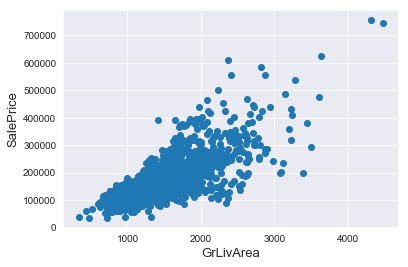

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
#graf je zdaj brez najbolj iztopajočih osamelcev

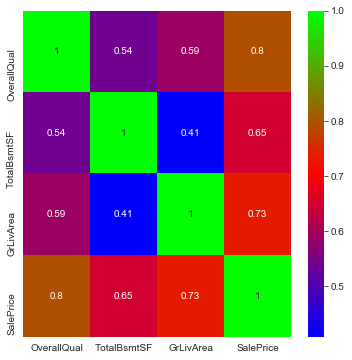

In [6]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.65]
plt.figure(figsize=(6,6))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="brg")
#vidimo da je z SalePrice najbolj povezan OverallQual

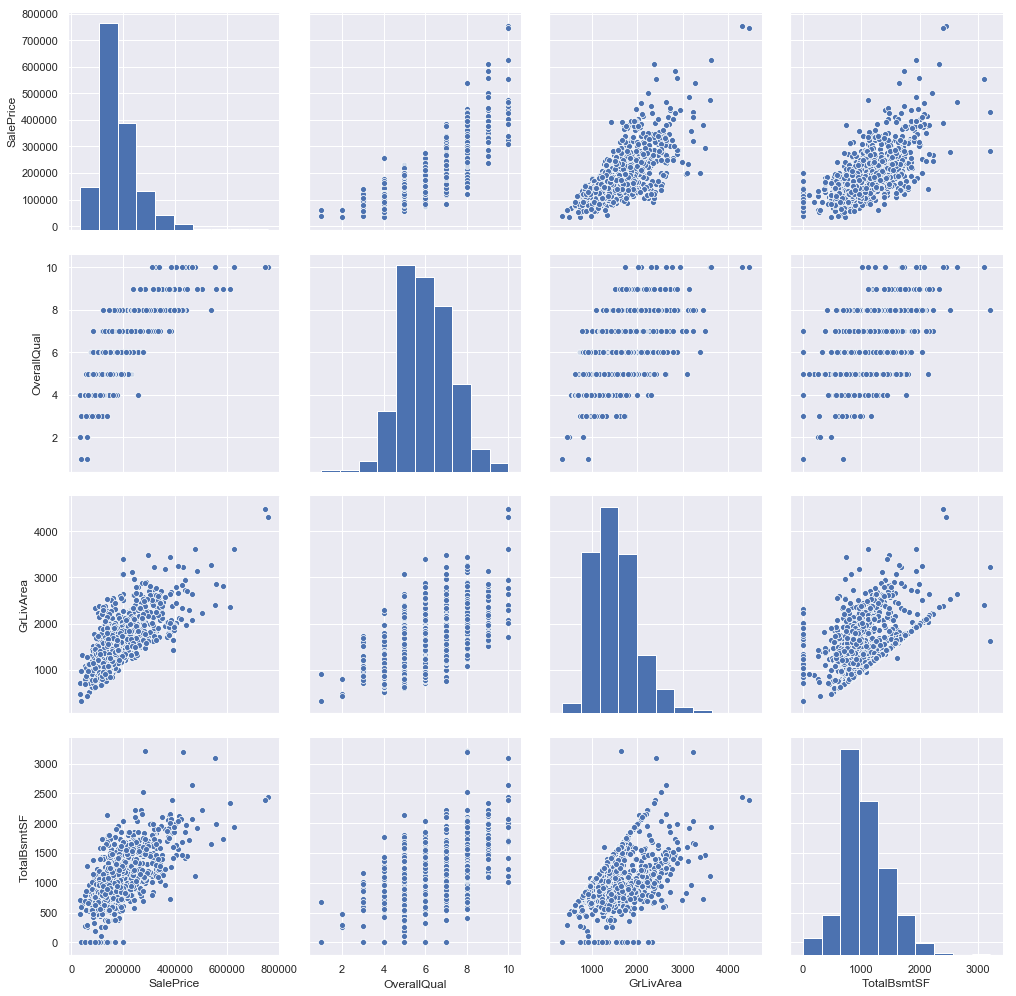

In [7]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF']
sns.pairplot(train[cols], size = 3.5)
plt.show();

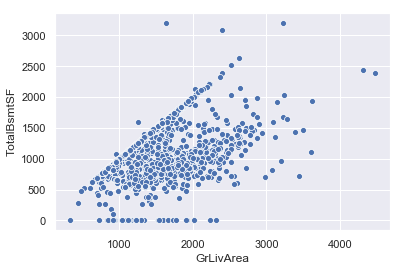

In [8]:
sns.scatterplot(train.GrLivArea,train.TotalBsmtSF)
plt.show() #opazimo kako linearno so povezane točke med TotalBsmtSF in GrLiveArea


 mu = 180932.92 and sigma = 79467.79



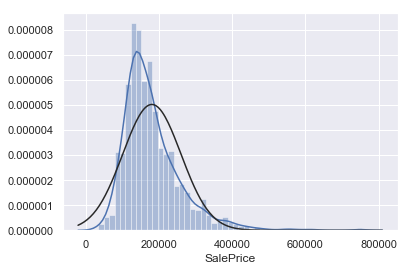

<Figure size 432x288 with 0 Axes>

In [9]:
sns.distplot(train['SalePrice'] , fit=norm);
fig = plt.figure()
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.show()


 mu = 12.02 and sigma = 0.40



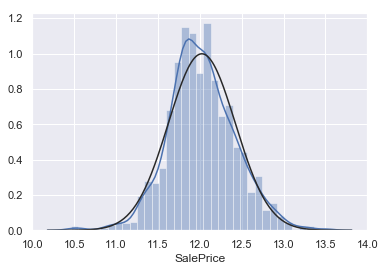

<Figure size 432x288 with 0 Axes>

In [10]:
#da dosežemo normalno distribucijo naredimo log transform
train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(train['SalePrice'] , fit=norm);
fig = plt.figure()
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.show()

In [11]:
#Missing data handling
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [12]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

In [13]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [14]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [15]:
all_data = all_data.drop(['Utilities'], axis=1)

In [16]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [17]:
mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [18]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [19]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()
#Ni več manjkajočih podatakov

,Missing Ratio


In [20]:
#Še pretvorba numeričnih spremenljivk, ki so ubistvu kategorične
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [21]:
#Label Encoding - vse tekstovne podatke pretvorimo v numerične za potrebe modela
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [22]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [23]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [24]:
#Box Cox transformacija podatkov v normalno obliko
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [25]:
#dummy data
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [26]:
#učna in testna
train = all_data[:ntrain]
test = all_data[ntrain:]
train.shape

(1458, 220)

In [27]:
#cross validation
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [28]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_score, train_test_split

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print(score)
print("Kernel Ridge score: {:.4f}(mean) {:.4f}(std)\n".format(score.mean(), score.std()))

[0.10653226 0.12033688 0.12733698 0.11021091 0.11185629]
Kernel Ridge score: 0.1153(mean) 0.0075(std)



In [29]:
KRRMd = KRR.fit(train.values,y_train)

In [30]:
print(np.expm1(KRRMd.predict(test.values)))

[118199.86988646 183668.57309369 181824.13504955 ... 174477.08304946
 104439.81767255 224781.39824469]


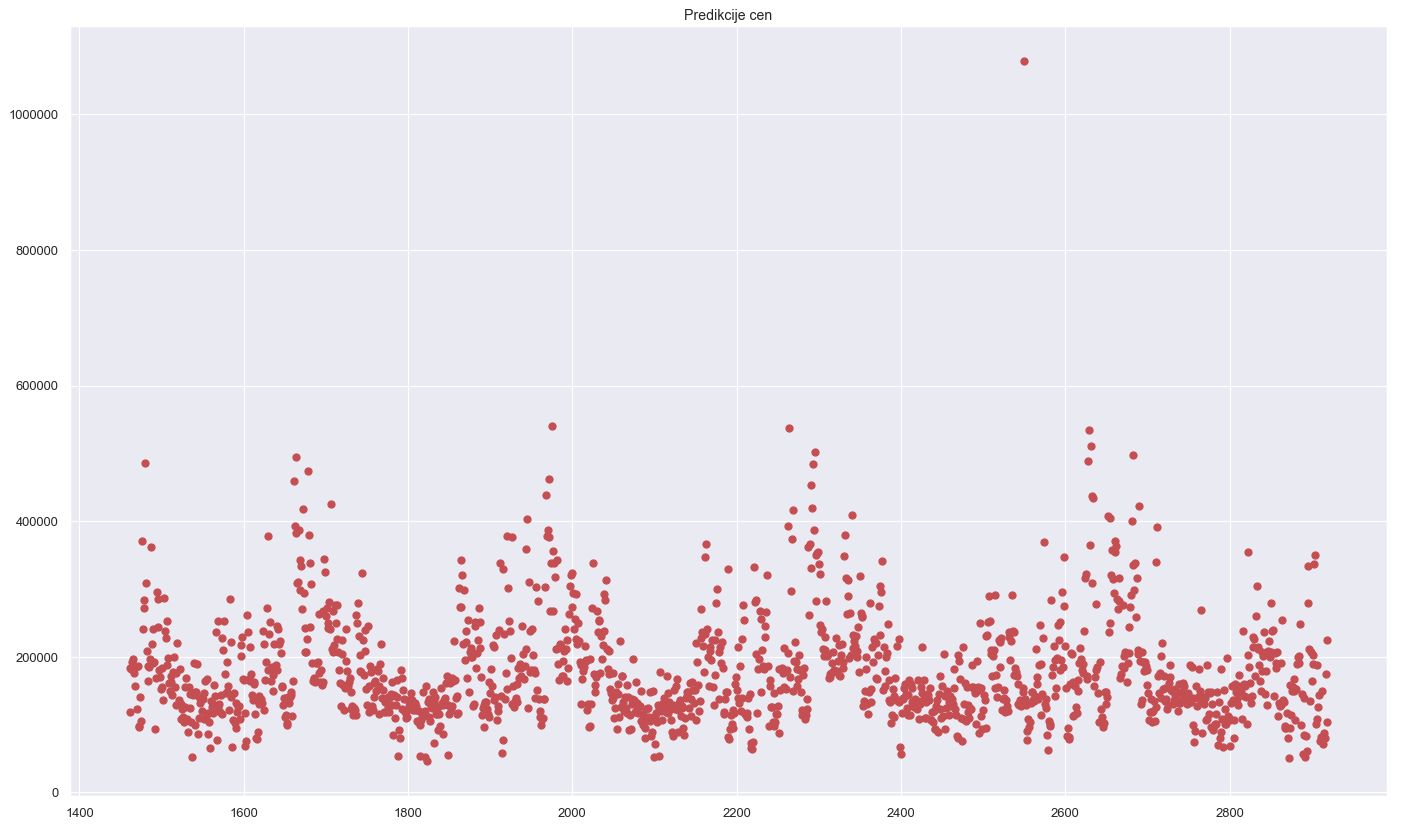

In [31]:
fig=plt.figure(figsize=(20, 12), dpi= 85, facecolor='W', edgecolor='k')
x=test_ID;
y=np.expm1(KRRMd.predict(test.values));
plt.scatter(x,y,color="R")
plt.title('Predikcije cen')
plt.show();

In [32]:
napovedi = pd.DataFrame()
napovedi['Id'] = test_ID
napovedi['SalePrice'] = y

In [33]:
napovedi

,Id,SalePrice
0,1461,118199.869886
1,1462,183668.573094
2,1463,181824.135050
3,1464,192756.781833
4,1465,197112.701062
5,1466,175652.990067
6,1467,185595.813027
7,1468,157016.050420
8,1469,184217.845332
9,1470,122374.248642
